### Suggestions:
##### 1) Reduced training set for faster training
##### 2) Low image quality (grey-scale)

####  **Importing Required Libraries**

**Objective**  
This section introduces the libraries and modules required for this lab. These libraries enable efficient data handling, preprocessing, and model building for TinyML applications.

**Key Components**  
- **TensorFlow**: A powerful framework for building and deploying machine learning models, especially suited for deep learning tasks.  
- **TensorFlow Datasets (TFDS)**: A module to download and preprocess datasets like PlantVillage efficiently.  
- **Keras Applications**: Provides pre-trained models such as MobileNet, optimized for resource-constrained environments like TinyML.  
- **Keras Layers and Models**: Used to customize the architecture for our binary classification task.  
- **Adam Optimizer**: A widely-used optimization algorithm for training neural networks efficiently.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
save_dir = '/content/drive/My Drive/TinyPlants'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



#### **Preparing the PlantVillage Dataset**

**Objective**  
This section focuses on loading, preprocessing, and splitting the PlantVillage dataset into training, validation, and test sets while converting it into a binary classification dataset.

**Steps**  
1. **Load the Dataset**: Utilize TensorFlow Datasets (TFDS) to download and load the PlantVillage dataset.  
2. **Define Healthy Classes**: Specify the "healthy" classes from the dataset's class list. All other classes are automatically labeled as "unhealthy."  
3. **Relabel the Dataset**: Implement a mapping function to convert multi-class labels into binary labels (`0` for healthy, `1` for unhealthy).  
4. **Split the Dataset**: Divide the dataset into training (40,000 samples), validation (7,000 samples), and test sets.  
5. **Preprocess Images**: Resize images to the input size expected by MobileNet and normalize pixel values to the range [0, 1].

**Outcome**  
This step produces preprocessed datasets ready for training, validation, and evaluation, tailored for binary classification tasks.


In [5]:
# Load the PlantVillage dataset
dataset, info = tfds.load('plant_village', with_info=True, as_supervised=True)

# Define the "healthy" classes
healthy_classes = [
    'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy',
    'Corn___healthy', 'Grape___healthy', 'Peach___healthy',
    'Pepper,_bell___healthy', 'Potato___healthy', 'Raspberry___healthy',
    'Soybean___healthy', 'Strawberry___healthy', 'Tomato___healthy'
]

# Get class names from the dataset info
class_names = info.features['label'].names

# Function to map original labels to binary labels
def map_to_binary_label(image, label):
    class_name = class_names[label]
    if class_name in healthy_classes:
        new_label = 0  # Healthy
    else:
        new_label = 1  # Unhealthy
    return image, new_label

# Corrected function to map original labels to binary labels
def map_to_binary_label(image, label):
    class_name = tf.gather(class_names, tf.cast(label, tf.int32))  # Convert label to int and get class name
    new_label = tf.cond(
        tf.reduce_any(tf.equal(class_name, healthy_classes)),
        lambda: tf.constant(0),  # Healthy
        lambda: tf.constant(1)   # Unhealthy
    )
    return image, new_label

# Apply the corrected mapping function
binary_train_dataset = dataset['train'].map(map_to_binary_label)


# Split into training, validation, and test sets
train_dataset = binary_train_dataset.take(40000)
val_dataset = binary_train_dataset.skip(40000).take(7000)
test_dataset = binary_train_dataset.skip(47000)

# Image preprocessing
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # Normalize to [0,1] range
    return image, label

# Preprocess the datasets
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


#### **Visualizing Healthy and Unhealthy Leaves**

**Objective**  
This section introduces a visualization step to better understand the dataset. It plots examples of healthy and unhealthy plant leaves from the training dataset.

**Steps**  
1. **Helper Functions**:  
   - `plot_images`: Displays a grid of images with labels.  
   - `collect_examples`: Extracts a specified number of healthy and unhealthy images for visualization.  
2. **Visualization**: Visualize 5 healthy and 5 unhealthy plant leaves from the training dataset.  
   - Healthy leaves are labeled as `Healthy`.  
   - Unhealthy leaves are labeled as `Unhealthy`.

**Outcome**  
This step helps participants familiarize themselves with the dataset and ensures the binary labeling was applied correctly. It also emphasizes the importance of understanding the dataset before training a model.


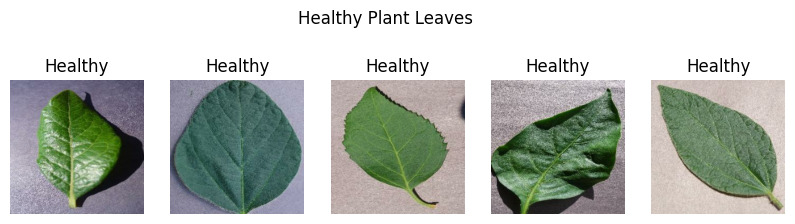

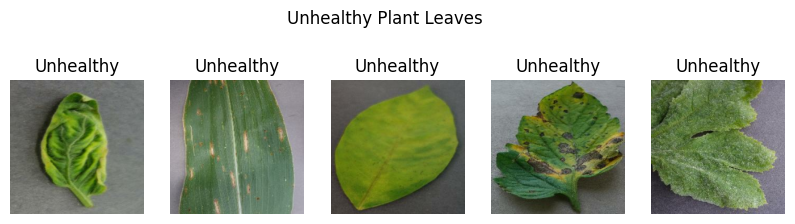

In [6]:
import matplotlib.pyplot as plt

# Helper function to display images with labels
def plot_images(images, labels, title):
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title('Healthy' if labels[i] == 0 else 'Unhealthy')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Function to collect 5 healthy and 5 unhealthy examples
def collect_examples(dataset, num_per_class=5):
    healthy_images = []
    unhealthy_images = []
    for image, label in dataset.unbatch():  # Unbatch to iterate over individual samples
        if len(healthy_images) < num_per_class and label.numpy() == 0:
            healthy_images.append(image.numpy())
        elif len(unhealthy_images) < num_per_class and label.numpy() == 1:
            unhealthy_images.append(image.numpy())
        # Stop once we have enough examples
        if len(healthy_images) == num_per_class and len(unhealthy_images) == num_per_class:
            break
    return healthy_images, unhealthy_images

# Collect examples from the training dataset
healthy_images, unhealthy_images = collect_examples(train_dataset)

# Plot healthy and unhealthy images
plot_images(healthy_images, [0] * len(healthy_images), title="Healthy Plant Leaves")
plot_images(unhealthy_images, [1] * len(unhealthy_images), title="Unhealthy Plant Leaves")


# Fine-Tuning MobileNetV2 with Mixed Precision for Binary Classification

## Objective
This section focuses on building and fine-tuning a pre-trained MobileNetV2 model with mixed precision to classify plant leaves as healthy or unhealthy. Mixed precision allows faster computation and reduced memory usage by leveraging the efficiency of lower-precision arithmetic.



## Steps

1. **Load MobileNetV2**: Use a pre-trained MobileNetV2 model with ImageNet weights, excluding the top layers to allow for custom modifications.

2. **Enable Mixed Precision**: Configure TensorFlow to use mixed precision by setting the global precision policy to `mixed_float16`. This enables compatible layers and operations to use 16-bit precision automatically while keeping the output layer and loss functions in 32-bit precision for stability.

  ### What is Mixed Precision?
  **Mixed precision training** uses both 16-bit (half-precision) and 32-bit (single-precision) floating-point data types during model training. In modern deep learning hardware, such as NVIDIA GPUs with Tensor Cores, operations in 16-bit precision are significantly faster than in 32-bit precision. Mixed precision training allows for:
  - **Faster computation**: 16-bit operations are optimized on supported hardware.
  - **Lower memory usage**: Reduces memory requirements, enabling larger batch sizes or more complex models.
  - **Maintained accuracy**: The model retains high numerical precision for critical operations (e.g., loss calculation and gradients) while benefiting from faster 16-bit arithmetic.

  ### Advantages of Mixed Precision
  - **Speed**: Reduces the time needed for each training step, especially when using GPUs with Tensor Cores.
  - **Memory Efficiency**: Enables the use of larger batch sizes or models with more parameters.
  - **Scalability**: Suitable for deploying resource-efficient models on edge devices or in production.

  With these optimizations, the model is ready for efficient inference tasks and can be deployed in environments with limited computational resources.

3. **Freeze Base Layers**: Prevent updates to the pre-trained weights during training to leverage pre-learned features effectively.

4. **Add Custom Layers**: Include a global average pooling layer, a dense layer for feature extraction, and an output layer for binary classification (using sigmoid activation). The output layer uses `dtype='float32'` to ensure compatibility with the binary cross-entropy loss.

5. **Compile the Model**: Use the Adam optimizer with a learning rate of 0.001, binary cross-entropy loss function, and accuracy as a performance metric.

6. **Optimize Dataset Pipeline**: Use TensorFlow's `tf.data` API to prefetch data, ensuring efficient data loading during training and validation.

7. **Train the Model**: Train the model using the prepared training and validation datasets for 10 epochs. The mixed precision policy improves training speed on supported hardware.

8. **Evaluate the Model**: Test the model on the test dataset to evaluate its performance and display the test accuracy.

9. **Save the Model**: Save the fine-tuned MobileNetV2 model in the recommended `.keras` format for future deployment or inference tasks.

## Outcome
By the end of this section, participants will have:
- Trained a compact, efficient model optimized for TinyML applications.
- Leveraged mixed precision training for faster computation and reduced memory consumption without compromising model accuracy.
- Saved the trained model in a modern format for deployment on resource-constrained devices.




In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='sigmoid', dtype='float32')(x)  # Ensure output dtype is float32

# Create the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Optimize dataset pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)



In [8]:

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model in Keras format
model.save(os.path.join(save_dir,'mobilenet_finetuned_binary_plant_village.keras'))

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 124s 88ms/step - accuracy: 0.9570 - loss: 0.1127 - val_accuracy: 0.9871 - val_loss: 0.0349
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 73ms/step - accuracy: 0.9877 - loss: 0.0360 - val_accuracy: 0.9703 - val_loss: 0.0791
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 78ms/step - accuracy: 0.9897 - loss: 0.0262 - val_accuracy: 0.9897 - val_loss: 0.0295
229/229 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.9891 - loss: 0.0304
Test Accuracy: 0.9882


## Saving the Model to Google Drive

This section demonstrates how to save the fine-tuned MobileNetV2 model to a folder named `TinyPlants` in your Google Drive. By following these steps, you can ensure that the trained model is stored securely and can be accessed later for deployment or further experimentation.

### Steps:
1. **Mount Google Drive**: Connect your Google Drive to the Colab environment to enable file saving and retrieval.
2. **Create Folder**: Check if the `TinyPlants` folder exists in your Google Drive. If not, create it automatically.
3. **Save the Model**: Save the fine-tuned model in the `.keras` format to the `TinyPlants` folder for easy organization and access.


In [9]:
import os
# Save the model in Keras format to the specified directory
# Define Google Drive save paths in the TinyPlants folder
save_dir = '/content/drive/My Drive/TinyPlants'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, 'mobilenet_finetuned_binary_plant_village.keras')
model.save(model_path)

print(f"Model saved to {model_path}")


Model saved to /content/drive/My Drive/TinyPlants/mobilenet_finetuned_binary_plant_village.keras


## Converting the Model to TensorFlow Lite with Integer Quantization

This section demonstrates how to convert the trained Keras model into a TensorFlow Lite model with integer quantization, ensuring that the input tensors have the correct dimensions required for TensorFlow Lite. Integer quantization optimizes the model for deployment on resource-constrained devices, like microcontrollers, while maintaining accuracy.

### Key Steps:

1. **Representative Dataset**:
   - A subset of the training data is used to calibrate the quantization process, ensuring accurate scaling of weights and activations during integer quantization.

2. **Correct Input Shape for Representative Dataset**:
   - TensorFlow Lite requires inputs to have a batch dimension, making the input shape `[batch_size, height, width, channels]`.
   - This issue is addressed by using `tf.expand_dims()` to add a batch dimension to the images in the representative dataset.

3. **Conversion Process**:
   - The TensorFlow Lite converter is configured to use integer quantization (`TFLITE_BUILTINS_INT8`) and fallback to TensorFlow operations (`SELECT_TF_OPS`) for unsupported layers.

4. **Save the Quantized Model**:
   - The quantized model is saved as `mobilenet_quantized_binary_plant_village.tflite` for deployment.

### Benefits of Integer Quantization:
- Reduces model size and memory usage, making it suitable for TinyML applications.
- Increases inference speed on devices with hardware acceleration for integer arithmetic.
- Maintains high accuracy through proper calibration using the representative dataset.

By the end of this section, the fine-tuned MobileNetV2 model is converted into a lightweight, quantized format, ready for deployment on edge devices.


In [10]:
import tensorflow as tf

# Load the .keras model
model = tf.keras.models.load_model(os.path.join(save_dir,'mobilenet_finetuned_binary_plant_village.keras'))

# Define the representative dataset for quantization
def representative_dataset():
    for image, _ in train_dataset.unbatch().take(100):  # Take 100 samples from training data
        image = tf.expand_dims(image, axis=0)  # Add a batch dimension
        yield [tf.cast(image, tf.float32)]

# Convert the loaded Keras model to TensorFlow Lite format with integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# Enable fallback to allow unsupported ops to use float
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,  # Use integer ops when possible
    tf.lite.OpsSet.SELECT_TF_OPS          # Fallback to TensorFlow ops if needed
]
# converter.inference_input_type = tf.int8  # Quantize input to int8
# converter.inference_output_type = tf.int8  # Quantize output to int8

# Convert the model
quantized_model = converter.convert()

# Save the quantized model
quantized_model_path = os.path.join(save_dir,'mobilenet_quantized_binary_plant_village.tflite')
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_model)

print(f"Quantized model saved as '{quantized_model_path}'")


Saved artifact at '/tmp/tmpsgkayws6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133969750365936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133969750415088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133969750417200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133969750410512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133969750412800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133969750422304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133969750414560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133969750423712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133969750423360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133969750421424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133969750379504

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model saved as '/content/drive/My Drive/TinyPlants/mobilenet_quantized_binary_plant_village.tflite'


In [11]:
import os

# Define Google Drive save paths in the TinyPlants folder
save_dir = '/content/drive/My Drive/TinyPlants'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

quantized_model_path = os.path.join(save_dir, 'mobilenet_quantized_binary_plant_village.tflite')
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_model)

print(f"Quantized model saved to Google Drive at '{quantized_model_path}'")

Quantized model saved to Google Drive at '/content/drive/My Drive/TinyPlants/mobilenet_quantized_binary_plant_village.tflite'


In [12]:
tflite_model_path = (os.path.join(save_dir,'mobilenet_quantized_binary_plant_village.tflite'))
with open(tflite_model_path, 'rb') as f:
    tflite_model = f.read()

In [1]:
import tensorflow as tf
import time
import os


# Load the original Keras model
original_model = tf.keras.models.load_model(os.path.join(save_dir,'mobilenet_finetuned_binary_plant_village.keras'))

# Load the TFLite quantized model
tflite_model_path = (os.path.join(save_dir,'mobilenet_quantized_binary_plant_village.tflite'))
with open(tflite_model_path, 'rb') as f:
    tflite_model = f.read()

# Helper function to evaluate the TFLite model
def evaluate_tflite_model(tflite_model, test_dataset):
    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    correct_predictions = 0
    total_samples = 0
    for image, label in test_dataset.unbatch():
        # Preprocess the image
        input_data = tf.cast(image, tf.int8 if input_details[0]['dtype'] == tf.int8 else tf.float32)
        input_data = tf.expand_dims(input_data, axis=0)  # Add batch dimension

        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data.numpy())
        interpreter.invoke()

        # Get the prediction
        output = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = tf.round(tf.sigmoid(output)).numpy()[0][0]
        if predicted_label == label.numpy():
            correct_predictions += 1
        total_samples += 1

    # Calculate accuracy
    return correct_predictions / total_samples

# Evaluate the original model
original_start_time = time.time()
original_test_loss, original_test_acc = original_model.evaluate(test_dataset, verbose=0)
original_latency = (time.time() - original_start_time) / len(list(test_dataset.unbatch()))
original_size = os.path.getsize((os.path.join(save_dir,'mobilenet_finetuned_binary_plant_village.keras'))) / 1024  # in KB

# Evaluate the TFLite model
tflite_start_time = time.time()
tflite_test_acc = evaluate_tflite_model(tflite_model, test_dataset)
tflite_latency = (time.time() - tflite_start_time) / len(list(test_dataset.unbatch()))
tflite_size = os.path.getsize(tflite_model_path) / 1024  # in KB

# Print the comparison results
print(f"Model Comparison:")
print(f"1. Model Size:")
print(f"   - Original Model: {original_size:.2f} KB")
print(f"   - TFLite Model: {tflite_size:.2f} KB")
print(f"2. Latency (seconds per sample):")
print(f"   - Original Model: {original_latency:.4f} s/sample")
print(f"   - TFLite Model: {tflite_latency:.4f} s/sample")
print(f"3. Accuracy on Test Data:")
print(f"   - Original Model: {original_test_acc:.4f}")
print(f"   - TFLite Model: {tflite_test_acc:.4f}")


NameError: name 'save_dir' is not defined

In [ ]:
import tensorflow as tf
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths for saved models
base_model_path = '/content/drive/My Drive/TinyPlants/mobilenet_finetuned_binary_plant_village.keras'
tflite_model_path = '/content/drive/My Drive/TinyPlants/mobilenet_quantized_binary_plant_village.tflite'

# Check if files exist
assert os.path.exists(base_model_path), "Base model file not found!"
assert os.path.exists(tflite_model_path), "TFLite model file not found!"

# Load the original model without the optimizer state
original_model = tf.keras.models.load_model(base_model_path, compile=False)

# Compile the model
original_model.compile(
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Load the TFLite quantized model content
with open(tflite_model_path, 'rb') as f:
    tflite_model = f.read()

# Helper function to evaluate the TFLite model
def evaluate_tflite_model(tflite_model, test_dataset):
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    correct_predictions = 0
    total_samples = 0

    for image, label in test_dataset.take(100):  # Use only 100 samples for evaluation
        # Preprocess image
        input_data = tf.image.resize(image, (224, 224))  # Resize image
        input_data = tf.cast(input_data / 255.0, tf.float32)  # Normalize image
        if input_details[0]['dtype'] == tf.int8:
            input_data = tf.cast(input_data * 127.0, tf.int8)  # Quantize image
        input_data = tf.expand_dims(input_data, axis=0)  # Add batch dimension

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data.numpy())
        interpreter.invoke()

        # Get prediction
        output = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = int(tf.round(tf.sigmoid(output)).numpy()[0][0])
        if predicted_label == label.numpy():
            correct_predictions += 1
        total_samples += 1

    return correct_predictions / total_samples

# Preprocess the test dataset to match model input requirements
def preprocess_dataset(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize image to (224, 224)
    image = tf.cast(image / 255.0, tf.float32)  # Normalize image to [0, 1]
    return image, label

# Unbatch, preprocess, and batch the test dataset correctly
test_dataset_subset = test_dataset.unbatch().map(preprocess_dataset).batch(32).prefetch(tf.data.AUTOTUNE)

# Evaluate the original model
original_test_loss, original_test_acc = original_model.evaluate(test_dataset_subset, verbose=0)

# Free memory after evaluating the original model
tf.keras.backend.clear_session()

# Evaluate the TFLite model
tflite_test_acc = evaluate_tflite_model(tflite_model, test_dataset_subset.unbatch())
original_size = os.path.getsize(base_model_path) / 1024  # KB
tflite_size = os.path.getsize(tflite_model_path) / 1024  # KB

# Print results
print(f"Model Comparison:")
print(f"1. Model Size:")
print(f"   - Original Model: {original_size:.2f} KB")
print(f"   - TFLite Model: {tflite_size:.2f} KB")
print(f"2. Accuracy on Test Data:")
print(f"   - Original Model: {original_test_acc:.4f}")
print(f"   - TFLite Model: {tflite_test_acc:.4f}")


In [ ]:
assert os.path.exists(tflite_model_path), f"TFLite model file not found at {tflite_model_path}"
print(f"TFLite model file exists: {tflite_model_path}")


In [ ]:
with open(tflite_model_path, 'rb') as f:
    tflite_model = f.read()

assert tflite_model, "Failed to load TFLite model content"
print(f"TFLite model loaded successfully, size: {len(tflite_model)} bytes")
